In [1]:
# Importing modules

import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import requests_cache

import sklearn.decomposition as sk_decom

# module for keras

#import tensorflow.keras as keras
#import tensorflow.keras.models
#import tensorflow.keras.layers

/home/alan/.local/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Define the cache to store the data

expire_after = datetime.timedelta(days=300)

local_cache = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

# Downloading the data of 0005.hk from yahoo finance

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 1, 11)

df = web.DataReader("0005.HK", 'yahoo', start, end, session=local_cache)

# Show the labels

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2468 entries, 2010-01-04 to 2020-01-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2468 non-null   float64
 1   Low        2468 non-null   float64
 2   Open       2468 non-null   float64
 3   Close      2468 non-null   float64
 4   Volume     2468 non-null   float64
 5   Adj Close  2468 non-null   float64
dtypes: float64(6)
memory usage: 135.0 KB


In [3]:
# Get the ndarray from the dataframe

adj_close = df["Adj Close"].values
volume    = df["Volume"].values

In [4]:
# Calculate the rate of changes of adj_close

adj_close_chg = (adj_close[1:-1] - adj_close[0:-2]) / adj_close[0:-2]

In [5]:
# Calculate the rate of changes of volume

volume_chg = (volume[1:-1] - volume[0:-2]) / (volume[1:-1] + volume[0:-2])

In [6]:
# Normalize the array adj_close_chg

tmp = np.sqrt(np.mean(np.square(adj_close_chg)))
adj_close_chg /= tmp

# Normalize the array volume

tmp = np.sqrt(np.mean(np.square(volume_chg)))
volume_chg /= tmp

In [7]:
# Split the 80% dataset to training set

adj_close_chg_training = adj_close_chg[:int(len(adj_close_chg)*0.8)]
volume_chg_training = volume_chg[:int(len(volume_chg)*0.8)]

# Split the 20% dataset to testing set

adj_close_chg_testing  = adj_close_chg[int(len(adj_close_chg)*0.8):]
volume_chg_testing  = volume_chg[int(len(volume_chg)*0.8):]

# Print the size of the above data sets for checking

print((adj_close_chg_training.shape), (volume_chg_training.shape))
print((adj_close_chg_testing.shape), (volume_chg_testing.shape))

(1972,) (1972,)
(494,) (494,)


In [8]:
# Number of steps to look advance

N_step = int(20)

# Generating training patterns

target_training = [adj_close_chg_training[i] for i in range(N_step,len(adj_close_chg_training))]
pattern_training = [np.concatenate((adj_close_chg_training[i-N_step:i],volume_chg_training[i-N_step:i]))
                    for i in range(N_step,len(adj_close_chg_training))]

target_training = np.array(target_training)
pattern_training = np.array(pattern_training)

# Generating testing patterns

target_testing = [adj_close_chg_testing[i] for i in range(N_step,len(adj_close_chg_testing))]
pattern_testing = [np.concatenate((adj_close_chg_testing[i-N_step:i],volume_chg_testing[i-N_step:i]))
                    for i in range(N_step,len(adj_close_chg_testing))]

target_testing = np.array(target_testing)
pattern_testing = np.array(pattern_testing)

In [9]:
# Making targets binary

tmp = np.heaviside(target_training, 0)
tmp = np.array([tmp, 1-tmp]).transpose()
target_training = tmp

tmp = np.heaviside(target_testing, 0)
tmp = np.array([tmp, 1-tmp]).transpose()
target_testing = tmp

In [10]:
pca_solver = sk_decom.PCA()
pca_solver.fit(pattern_training)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca_project = np.matmul(pca_solver.components_ , pattern_training.transpose())

In [12]:
up_0 = pca_project[0][target_training[:,0]==1]
dn_0 = pca_project[0][target_training[:,0]==0]
up_1 = pca_project[1][target_training[:,0]==1]
dn_1 = pca_project[1][target_training[:,0]==0]

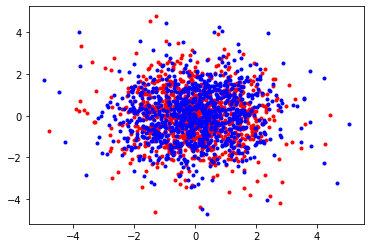

In [13]:
import matplotlib.pyplot as plt

plt.plot(up_0, up_1, "r.")
plt.plot(dn_0, dn_1, "b.")
